In [1]:
import os
import importlib
from timeit import timeit
import logging
import sys
import importlib
import time
import multiprocessing as mp
import multiprocessing.pool

import numpy as np
import pandas as pd
import scipy
import h5py
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import numba
import sklearn.linear_model

import ms_utils
import browser
import interface
import ms_database
import ms_run_files

import sandbox

import line_profiler
profile = line_profiler.LineProfiler()
# heat.evolve = profile(heat.evolve)
# profile.print_stats()

def reload():
    importlib.reload(ms_run_files)
    importlib.reload(ms_utils)
    importlib.reload(browser)
    importlib.reload(interface)
    importlib.reload(sandbox)
    importlib.reload(ms_database)
   

In [ ]:
def get_candidate_peptide_indices_for_nodes(
    inet,
    database,
    parameters
):
    # TODO: Docstring
    ms_utils.LOGGER.info(
        f"Writing node candidates to {inet.file_name}"
    )
    max_ppm = parameters["annotation_ppm"]
    self_mzs = inet.get_ion_coordinates("FRAGMENT_MZ")
    mz_order = np.argsort(self_mzs)
    database_mzs = database.get_fragment_coordinates("mz")
    mz_transform = np.log(self_mzs[mz_order]) * 10**6
    low_limits = np.searchsorted(
        np.log(database_mzs) * 10**6,
        mz_transform - max_ppm,
        "left"
    )
    high_limits = np.searchsorted(
        np.log(database_mzs) * 10**6,
        mz_transform + max_ppm,
        "right"
    )
    inv_order = np.argsort(mz_order)
    return low_limits[inv_order], high_limits[inv_order]


@numba.njit(nogil=True, cache=True)
def score_annotations(
    candidates,
    edge_contributions,
    indptr,
    indices,
    peptide_pointers,
    low_peptide_indices,
    high_peptide_indices,
    peptide_count,
):
    annotated_ions = np.empty(candidates.shape[0], np.int64)
    annotated_peptides = np.empty(candidates.shape[0], np.int64)
    annotated_scores = np.empty(candidates.shape[0], np.float64)
    current_annotation_index = 0
    for index in np.flatnonzero(candidates):
        local_edge_contributions = edge_contributions[indptr[index]: indptr[index + 1]]
        good_edges = np.flatnonzero(local_edge_contributions > 0)
        if good_edges.shape[0] == 0:
            continue
        neighbors = indices[indptr[index]: indptr[index + 1]][good_edges]
        local_edge_contributions = local_edge_contributions[good_edges]
        l = low_peptide_indices[index]
        h = high_peptide_indices[index]
        candidate_peptides = peptide_pointers[l:h]
        candidate_peptide_scores = np.zeros(peptide_count, np.int64)
        for edge_contribution, neighbor_index in zip(local_edge_contributions, neighbors):
            l = low_peptide_indices[neighbor_index]
            h = high_peptide_indices[neighbor_index]
            if l == h:
                continue
            neighbor_peptides = peptide_pointers[l:h]
            candidate_peptide_scores[neighbor_peptides] += edge_contribution
        candidate_peptide_scores = candidate_peptide_scores[candidate_peptides]
        hits = np.flatnonzero(candidate_peptide_scores)
        if hits.shape[0] == 0:
            continue
        candidate_peptides = candidate_peptides[hits]
        candidate_peptide_scores = candidate_peptide_scores[hits]
    #     count_frequency = np.bincount(candidate_peptide_counts)
    #     if count_frequency[-1] != 1:
    #         continue
    #     print(index, candidate_peptides, candidate_peptide_counts)
        max_index = np.argmax(candidate_peptide_scores)
        peptide = candidate_peptides[max_index]
        score = candidate_peptide_scores[max_index]
        annotated_ions[current_annotation_index] = index
        annotated_peptides[current_annotation_index] = peptide
        annotated_scores[current_annotation_index] = score
        current_annotation_index += 1
    annotated_ions = annotated_ions[:current_annotation_index]
    annotated_peptides = annotated_peptides[:current_annotation_index]
    annotated_scores = annotated_scores[:current_annotation_index]
    return annotated_ions, annotated_peptides, annotated_scores

In [ ]:
inet = ms_run_files.HDF_Network_File(
    "/home/sander/Documents/Proteomics/data/ecoli_test/28Oct2016_068.inet.hdf"
)
evi = ms_run_files.HDF_Evidence_File(inet)
database = ms_database.HDF_Database_File(
    "/home/sander/Documents/Proteomics/data/databases/crap_ecoli_concatenated_decoy.hdf"
)
parameters = ms_utils.read_parameters_from_json_file(default="annotation")

In [ ]:
low_peptide_indices, high_peptide_indices = get_candidate_peptide_indices_for_nodes(
    inet,
    database,
    parameters
)
peptide_pointers = database.get_fragment_coordinates("peptide_index")
indptr, indices, edge_pointers = inet.get_edges(symmetric=True, return_pointers=True)
positive_counts = evi.get_edges()
negative_counts = evi.get_edges(positive=False)
peptide_sequences = database.read_dataset("sequence", "peptides")
decoys = database.read_dataset("decoy", "peptides")

In [ ]:
# edge_contributions = positive_counts[edge_pointers] == 9
edge_contributions = positive_counts[edge_pointers] - negative_counts[edge_pointers]
# edge_contributions = positive_counts[edge_pointers] >= 4
np.bincount(edge_contributions + 10)

In [ ]:
candidates = (high_peptide_indices > low_peptide_indices)
thread_count = 8
with multiprocessing.pool.ThreadPool(thread_count) as p:
    results = p.starmap(
        score_annotations,
        [
            (
                candidates[i::thread_count],
                edge_contributions,
                indptr,
                indices,
                peptide_pointers,
                low_peptide_indices,
                high_peptide_indices,
                peptide_sequences.shape[0],
            ) for i in range(thread_count)
        ]
    )
annotated_ions = np.concatenate([r[0] for r in results])
annotated_peptides = np.concatenate([r[1] for r in results])
annotated_scores = np.concatenate([r[2] for r in results])
annotated_decoys = decoys[annotated_peptides]

In [ ]:
for i in range(int(np.max(annotated_scores))):
    print(i, np.bincount(annotated_decoys[annotated_scores > i]))

In [ ]:
max_i = 519

print(np.argmax(annotated_scores))

annotated_ions[max_i], annotated_peptides[max_i], annotated_scores[max_i]

In [ ]:
i = 42853
print(6659 in peptide_pointers[low_peptide_indices[i]: high_peptide_indices[i]])
p = np.flatnonzero(peptide_pointers == 6659)
p

In [ ]:
# z = np.concatenate(
#     [
#         280718 in peptide_pointers[
#             low_peptide_indices[n]: high_peptide_indices[n]
#         ] for n in indices[indptr[i]: indptr[i+1]]
#     ]
# )
# # np.bincount(z)[p]
# z
l = 0
for n in indices[indptr[i]: indptr[i+1]]:
    l += np.any(np.isin(p, np.arange(low_peptide_indices[n], high_peptide_indices[n])))
#     l += 280718 in peptide_pointers[
#         low_peptide_indices[n]: high_peptide_indices[n]
#     ]
    
l

In [ ]:
np.bincount(decoys)

In [ ]:
@numba.njit(cache=True, nogil=True)
def annotate_network(
    queries,
    indptr,
    indices,
    edge_pointers,
    selected_edges,
    low_limits,
    high_limits,
    peptide_pointers,
):
    peptide_count = np.max(peptide_pointers) + 1
    count = len(queries)
    score_results = np.empty(count, np.float64)
    fragment_results = np.empty(count, np.int64)
    index_results = np.empty(count, np.int64)
    count_results = np.empty(count, np.int64)
    current_i = 0
    for ion_index in queries:
        ion_start = indptr[ion_index]
        ion_end = indptr[ion_index + 1]
        good_neighbors = selected_edges[edge_pointers[ion_start: ion_end]]
        if np.all(~good_neighbors):
            continue
        neighbors = indices[ion_start: ion_end][good_neighbors]
        candidates = np.zeros(peptide_count, np.int64)
        for neighbor_ion_index in neighbors:
            peptide_low = low_limits[neighbor_ion_index]
            peptide_high = high_limits[neighbor_ion_index]
            if peptide_low == peptide_high:
                continue
            peptides = peptide_pointers[peptide_low: peptide_high]
            candidates[peptides] += 1
        peptide_low = low_limits[ion_index]
        peptide_high = high_limits[ion_index]
        if peptide_low == peptide_high:
            continue
        peptides = peptide_pointers[peptide_low: peptide_high]
        local_candidates = candidates[peptides]
        frequencies = np.bincount(local_candidates)
        frequencies = np.cumsum(frequencies[:0:-1])[::-1]
        for regression_index, value in enumerate(frequencies):
            if value == 1:
                break
        else:
            continue
        if regression_index < 2:
            continue
        max_count = (len(frequencies) - 1)
        regression_constant = np.log(frequencies[0])
        regression_slope = (np.log(frequencies[regression_index]) - regression_constant) / regression_index
        score = regression_constant + regression_slope * max_count
        if score < 0:
            score_results[current_i] = -score
            hit_index = np.flatnonzero(local_candidates == max_count + 1)[0]
            fragment = peptide_low + hit_index
            fragment_results[current_i] = fragment
            index_results[current_i] = ion_index
            count_results[current_i] = max_count
            current_i += 1
    return (
        score_results[:current_i],
        fragment_results[:current_i],
        index_results[:current_i],
        count_results[:current_i]
    )


In [ ]:
inet = ms_run_files.HDF_Network_File(
    "/home/sander/Documents/Proteomics/data/ecoli_test/28Oct2016_068.inet.hdf"
)
evi = ms_run_files.HDF_Evidence_File(inet)
database = ms_database.HDF_Database_File(
    "/home/sander/Documents/Proteomics/data/databases/crap_ecoli_concatenated_decoy.hdf"
)
parameters = ms_utils.read_parameters_from_json_file(default="annotation")
parameters["edge_threshold"] = "2 * (positive_edges - negative_edges) > evidence_run_count"
parameters["edge_threshold"] =  "positive_edges > negative_edges"
import pyteomics
import numexpr as ne

In [ ]:
threads = 8
# LOGGER.info(f"Reading {inet.file_name}")
inet_mzs = inet.get_ion_coordinates("FRAGMENT_MZ")
mz_order = np.argsort(inet_mzs)
spectra_log_mzs = np.log(inet_mzs[mz_order]) * 10**6
indptr, indices, edge_pointers = inet.get_edges(symmetric=True, return_pointers=True)
positive_counts = evi.get_edges()
negative_counts = evi.get_edges(positive=False)
# LOGGER.info(f"Reading database {database.file_name}")
peptide_pointers = database.get_fragment_coordinates("peptide_index")
database_log_mzs = np.log(database.get_fragment_coordinates("mz")) * 10**6
# LOGGER.info(
#     f"Matching fragments of {mgf_file_name} with {database.file_name}"
# )
low_limits = np.searchsorted(
    database_log_mzs,
    spectra_log_mzs - parameters["annotation_ppm"],
    "left"
)
high_limits = np.searchsorted(
    database_log_mzs,
    spectra_log_mzs + parameters["annotation_ppm"],
    "right"
)
inv_order = np.argsort(mz_order)
# LOGGER.info(
#     f"Annotating fragments of {mgf_file_name} with {database.file_name}"
# )

In [ ]:
selected_edges = ne.evaluate(
    parameters["edge_threshold"],
    local_dict={
        "positive_edges": evi.get_edges(),
        "negative_edges": evi.get_edges(positive=False),
        "evidence_run_count": evi.run_count
    },
    global_dict={},
)
with multiprocessing.pool.ThreadPool(threads) as p:
    results = p.starmap(
        annotate_network,
        [
            (
                np.arange(i, inet.node_count, threads),
                indptr,
                indices,
                edge_pointers,
                selected_edges,
                low_limits[inv_order],
                high_limits[inv_order],
                peptide_pointers,
            ) for i in range(threads)
        ]
    )
scores = np.concatenate([r[0] for r in results])
fragments = np.concatenate([r[1] for r in results])
ion_indices = np.concatenate([r[2] for r in results])
count_results = np.concatenate([r[3] for r in results])
del results

In [ ]:
def export_annotated_csv(
    scores,
    fragments,
    ion_indices,
    count_results,
    inet,
    database,
    peptide_pointers,
    out_file_name,
):
#     LOGGER.info(f"Exporting {out_file_name}")
    peptides = peptide_pointers[fragments]
    decoys = database.read_dataset("decoy", "peptides")
    peptide_modifications = database.read_dataset("modifications", "peptides")
    peptide_sequences = database.read_dataset("sequence", "peptides")
    # selection = np.flatnonzero((scores < score_cutoff) & (~decoys[peptides]))
    fragment_ion_numbers = database.get_fragment_coordinates("ionnumber")
    fragment_is_y_ion = database.get_fragment_coordinates("y_ion")
    self_coordinates = inet.get_ion_coordinates(inet.dimensions)
    self_ints = inet.get_ion_coordinates("FRAGMENT_LOGINT")
    with open(out_file_name, "w") as raw_outfile:
        outfile = csv.writer(raw_outfile)
        header = ["Fragment_index"]
        header += inet.dimensions
        header += [
            "Fragment_ion_number",
            "Fragment_is_y_ion",
            "Peptide_sequence",
            "peptide_mods",
            "Score",
            "Count",
            "Decoy"
        ]
        outfile.writerow(header)
        for i, ion_index in enumerate(ion_indices):
            fragment_index = fragments[i]
            peptide_index = peptides[i]
            row = [ion_index]
            row += [self_coordinate[ion_index] for self_coordinate in self_coordinates]
            row += [
                fragment_ion_numbers[fragment_index],
                fragment_is_y_ion[fragment_index],
                peptide_sequences[peptide_index],
                peptide_modifications[peptide_index],
                scores[i],
                count_results[i],
                decoys[peptide_index],
            ]
            outfile.writerow(row)

In [ ]:
import csv
export_annotated_csv(
    scores,
    fragments,
    ion_indices,
    count_results,
    inet,
    database,
    peptide_pointers,
    out_file_name="/home/sander/Documents/Sandbox/aaa.csv",
)

In [ ]:
decoys = database.read_dataset("decoy", "peptides")
peptides = peptide_pointers[fragments]
target_scores = scores[~decoys[peptides]]
decoy_scores = scores[decoys[peptides]]
scores, peptides, target_scores.shape, decoy_scores.shape
score_cutoff = 3
ts = np.sum(target_scores > score_cutoff)
ds = np.sum(decoy_scores > score_cutoff)
ts, ds, 1 - ts/(ts+ds)

In [ ]:
np.bincount(selected_edges)

In [ ]:
spectra[0]['params']['rtinseconds']

In [ ]:
import pyteomics.mgf
# mgf_file_name = "/home/sander/Documents/Sandbox/test_msfragger/LFQ_TT5600_DDA_Micro_120_Min_Ecoli_01.mgf"
mgf_file_name = "/home/sander/Documents/Sandbox/test_msfragger/LFQ_TT5600_GP_4sec_cycletime_Ecoli_500_600.mgf"
spectra = [spectrum for spectrum in pyteomics.mgf.read(mgf_file_name)]
self_mzs = np.concatenate([spectrum["m/z array"] for spectrum in spectra])
self_ints = np.concatenate([spectrum["intensity array"] for spectrum in spectra])
spec_indptr = np.empty(len(spectra) + 1, np.int64)
spec_indptr[0] = 0
spec_indptr[1:] = np.cumsum([len(spectrum["m/z array"]) for spectrum in spectra])

In [ ]:
db = ms_database.HDF_Database_File(parameters["database_file_name"])
db_mzs = db.get_fragment_coordinates("mz")
peptide_pointers = db.get_fragment_coordinates("peptide_index")
peptide_sequences = db.read_dataset("sequence", "peptides")
peptide_modifications = db.read_dataset("modifications", "peptides")
decoys = db.read_dataset("decoy", "peptides")

In [ ]:
max_ppm = parameters["annotation_ppm"]
mz_order = np.argsort(self_mzs)
mz_transform = np.log(self_mzs[mz_order]) * 10**6
low_limits = np.searchsorted(
    np.log(db_mzs) * 10**6,
    mz_transform - max_ppm,
    "left"
)
high_limits = np.searchsorted(
    np.log(db_mzs) * 10**6,
    mz_transform + max_ppm,
    "right"
)
inv_order = np.argsort(mz_order)
low_limits = low_limits[inv_order]
high_limits = high_limits[inv_order]

In [ ]:
@numba.njit(cache=True, nogil=True)
def annotate_mgf(
    queries,
    spec_indptr,
    low_limits,
    high_limits,
    peptide_pointers,
):
    peptide_count = np.max(peptide_pointers)
    count = 0
    for s in queries:
        count += spec_indptr[s + 1] - spec_indptr[s]
    score_results = np.zeros(count, np.float64)
    fragment_results = np.zeros(count, np.int64)
    index_results = np.zeros(count, np.int64)
    count_results = np.zeros(count, np.int64)
    current_i = 0
    for spectrum_index in queries:
        spectrum_start = spec_indptr[spectrum_index]
        spectrum_end = spec_indptr[spectrum_index + 1]
        candidates = np.zeros(peptide_count, np.int64)
        for ion_index in range(spectrum_start, spectrum_end):
            peptide_low = low_limits[ion_index]
            peptide_high = high_limits[ion_index]
            if peptide_low == peptide_high:
                continue
            peptides = peptide_pointers[peptide_low: peptide_high]
            candidates[peptides] += 1
        for ion_index in range(spectrum_start, spectrum_end):
            peptide_low = low_limits[ion_index]
            peptide_high = high_limits[ion_index]
            if peptide_low == peptide_high:
                continue
            peptides = peptide_pointers[peptide_low: peptide_high]
            local_candidates = candidates[peptides]
            frequencies = np.bincount(local_candidates)
            frequencies = np.cumsum(frequencies[:0:-1])[::-1]
            for regression_index, value in enumerate(frequencies):
                if value == 1:
                    break
            else:
                continue
            if regression_index < 2:
                continue
            max_count = (len(frequencies) - 1)
            regression_constant = np.log(frequencies[0])
            regression_slope = (np.log(frequencies[regression_index]) - regression_constant) / regression_index
            score = regression_constant + regression_slope * max_count
            if score < 0:
                score_results[current_i] = score
                hit_index = np.flatnonzero(local_candidates == max_count + 1)[0]
                fragment = peptide_low + hit_index
                fragment_results[current_i] = fragment
                index_results[current_i] = ion_index
                count_results[current_i] = max_count
                current_i += 1
    return (
        score_results[:current_i],
        fragment_results[:current_i],
        index_results[:current_i],
        count_results[:current_i]
    )

In [ ]:
# scores, fragments, ion_indices, count_results = calculate_scores(
# #     queries=np.arange(spec_indptr.shape[0] - 1),
#     queries=np.arange(100),
#     spec_indptr=spec_indptr,
#     low_limits=low_limits,
#     high_limits=high_limits,
#     peptide_count=len(peptide_sequences),
#     peptide_pointers=peptide_pointers,
# )
# peptides = peptide_pointers[fragments]

In [ ]:
with multiprocessing.pool.ThreadPool(thread_count) as p:
    results = p.starmap(
        annotate_mgf,
        [
            (
                np.arange(i, spec_indptr.shape[0] - 1, thread_count),
                spec_indptr,
                low_limits,
                high_limits,
                len(peptide_sequences),
                peptide_pointers,
            ) for i in range(thread_count)
        ]
    )
scores = np.concatenate([r[0] for r in results])
fragments = np.concatenate([r[1] for r in results])
ion_indices = np.concatenate([r[2] for r in results])
count_results = np.concatenate([r[3] for r in results])
del results

In [ ]:
peptides = peptide_pointers[fragments]
target_scores = scores[~decoys[peptides]]
decoy_scores = scores[decoys[peptides]]
scores, peptides, target_scores.shape, decoy_scores.shape
score_cutoff = -5
ts = np.sum(target_scores < score_cutoff)
ds = np.sum(decoy_scores < score_cutoff)
ts, ds, 1-ts/(ts+ds)

In [ ]:
a, b = np.unique(peptides[(scores < score_cutoff) & (~decoys[peptides])], return_counts=True)
for i in zip(peptide_sequences[a], peptide_modifications[a], b):
    print(i)
# for i in np.unique(peptide_sequences[a]):
#     print(i)

In [ ]:
import csv
def export_annotated_csv(
    scores,
    fragments,
    ion_indices,
    spectra,
    spec_indptr,
    decoys,
    peptide_sequences,
    peptide_modifications,
    score_cutoff,
    proteins,
    self_mzs,
    self_ints,
    file_name,
    db,
    peptide_pointers,
    count_results,
):
    peptides = peptide_pointers[fragments]
    selection = np.flatnonzero((scores < score_cutoff) & (~decoys[peptides]))
    fragment_ion_numbers = db.get_fragment_coordinates("ionnumber")
    fragment_is_y_ion = db.get_fragment_coordinates("y_ion")
    spectrum_indices1 = np.searchsorted(
        spec_indptr,
        ion_indices,
        "right"
    ) - 1
    with open(file_name, "w") as raw_outfile:
        outfile = csv.writer(raw_outfile)
        header = [
            "Fragment_index",
            "Fragment_mz",
            "Fragment_int",
            "Fragment_ion_number",
            "Fragment_is_y_ion",
            "Spectrum_title",
            "Peptide_sequence",
            "peptide_mods",
            "Score",
            "Count",
#             "Protein",
        ]
        outfile.writerow(header)
        for i in selection:
            ion_index = ion_indices[i]
            fragment_index = fragments[i]
            peptide_index = peptides[i]
            spectrum_index = spectrum_indices1[i]
            row = [
                ion_index,
                self_mzs[ion_index],
                self_ints[ion_index],
                fragment_ion_numbers[fragment_index],
                fragment_is_y_ion[fragment_index],
                spectra[spectrum_index]['params']['title'],
                peptide_sequences[peptide_index],
                peptide_modifications[peptide_index],
                scores[i],
                count_results[i],
            ]
            outfile.writerow(row)
        

In [ ]:
export_annotated_csv(
    scores=scores,
    fragments=fragments,
    ion_indices=ion_indices,
    spectra=spectra,
    spec_indptr=spec_indptr,
    decoys=decoys,
    peptide_sequences=peptide_sequences,
    peptide_modifications=peptide_modifications,
    score_cutoff=-5,
    proteins=None,
    self_mzs=self_mzs,
    self_ints=self_ints,
    file_name="/home/sander/Downloads/result_UnicityF.csv",
    db=db,
    peptide_pointers=peptide_pointers,
    count_results=count_results,
)

In [ ]:
%matplotlib notebook

plt.plot(
    np.percentile(target_scores, range(101)),
    range(101)
#     *np.unique(
#         np.round(target_scores, 1),
#         return_counts=True
#     )
)
plt.plot(
    np.percentile(decoy_scores, range(101)),
    range(101)
#     *np.unique(
#         np.round(decoy_scores, 1),
#         return_counts=True
#     )
)

In [ ]:
maxi=1000
queries = range(maxi)
count = 0
for s in queries:
    count += spec_indptr[s + 1] - spec_indptr[s]
queries = iter(range(maxi))

In [ ]:
peptide_count = len(peptide_sequences),
while True:
    spectrum_index = next(queries)
    if True:
        spectrum_start = spec_indptr[spectrum_index]
        spectrum_end = spec_indptr[spectrum_index + 1]
        candidates = np.zeros(peptide_count, np.int64)
        for ion_index in range(spectrum_start, spectrum_end):
            peptide_low = low_limits[ion_index]
            peptide_high = high_limits[ion_index]
            if peptide_low == peptide_high:
                continue
            peptides = peptide_pointers[peptide_low: peptide_high]
            candidates[peptides] += 1
        for ion_index in range(spectrum_start, spectrum_end):
            peptide_low = low_limits[ion_index]
            peptide_high = high_limits[ion_index]
            if peptide_low == peptide_high:
                continue
            peptides = peptide_pointers[peptide_low: peptide_high]
            local_candidates = candidates[peptides]
            frequencies = np.bincount(local_candidates)
            frequencies = np.cumsum(frequencies[:0:-1])[::-1]
            for regression_index, value in enumerate(frequencies):
                if value == 1:
                    break
            else:
                continue
            if regression_index < 2:
                continue
            max_count = (len(frequencies) - 1)
            regression_constant = np.log(frequencies[0])
            regression_slope = (np.log(frequencies[regression_index]) - regression_constant) / regression_index
            score = regression_constant + regression_slope * max_count
            if score < 0:
                score_results[current_i] = score
                hit_index = np.flatnonzero(local_candidates == max_count + 1)[0]
                fragment = peptide_low + hit_index
                fragment_results[current_i] = fragment
                index_results[current_i] = ion_index
                current_i += 1
                break
        else:
            continue
        break

In [ ]:
%matplotlib notebook

# plt.plot(np.diff(frequencies[::-1])[::-1], marker=".")
plt.plot(np.log(frequencies), marker=".")
plt.plot([0, max_count], [regression_constant, score])

# for ion_index in range(start, end):
#     peps = peptide_pointers[low_limits[ion_index]: high_limits[ion_index]]
#     frequencies = np.bincount(candidates[peps])
#     frequencies = np.cumsum(frequencies[:0:-1])[::-1]
#     if (len(frequencies) < 2):
#         continue
#     if (frequencies[-1] != 1):
#         plt.plot(np.log(frequencies), marker=".")
    

In [ ]:
spectra[0]

In [2]:
file_name = "/home/sander/Documents/Proteomics/data/swath/LFQ_TT5600_SWATH_Micro_120_Min_Ecoli_01.annotation.csv"
df = pd.read_csv(file_name)

In [3]:
df

,Fragment_index,Fragment_mz,Fragment_int,Fragment_ion_type,Fragment_ion_number,Spectrum_title,Spectrum_pepmass,Spectrum_rtinseconds,Peptide_sequence,Peptide_mods,Peptide_length,Likelihood,Count,Candidates,Spectrum_size,Decoy
0,245587,401.193058,0.059393,B,3,LFQ_TT5600_SWATH_Micro_120_Min_Ecoli_01.5202.5...,403.85,283.200,MRPSLDIEQVATGEHWYGQQAVEK,1|Oxidation,24,0.833333,5,216,228,False
1,361374,455.144166,0.126522,Y,4,LFQ_TT5600_SWATH_Micro_120_Min_Ecoli_01.6420.6...,773.20,349.362,HADADSSM,8|Oxidation,8,0.889568,4,82,107,True
2,438395,228.172284,0.177032,B,2,LFQ_TT5600_SWATH_Micro_120_Min_Ecoli_01.7152.7...,403.85,389.317,KVGAVPAWAGLLIGDTGVK,-,19,0.765192,7,1401,347,True
3,438588,404.238068,0.295254,B,3,LFQ_TT5600_SWATH_Micro_120_Min_Ecoli_01.7152.7...,403.85,389.317,MKKPNHSGSGQIR,1|Oxidation,13,1.000000,3,1,347,False
4,438595,405.199973,1.273375,Y,3,LFQ_TT5600_SWATH_Micro_120_Min_Ecoli_01.7152.7...,403.85,389.317,SLEASVEEK,-,9,0.746805,7,961,347,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5927384,65833420,582.159671,0.143092,Y,5,LFQ_TT5600_SWATH_Micro_120_Min_Ecoli_01.140644...,874.70,7654.101,ETQQNSSSSSSSSTSARSDDDSM,-,23,1.000000,2,1,468,False
5927385,65833441,642.194708,0.300579,Y,5,LFQ_TT5600_SWATH_Micro_120_Min_Ecoli_01.140644...,874.70,7654.101,ESVSGPLSLHVTTGFEQLFVRFDCSNM,24|Carbamidomethyl|27|Oxidation,27,0.835586,6,15,468,True
5927386,65833552,897.458842,0.266498,Y,7,LFQ_TT5600_SWATH_Micro_120_Min_Ecoli_01.140644...,874.70,7654.101,GHLSIESGDAATYHRDDNLK,-,20,0.642959,9,1352,468,True
5927387,65833568,965.302308,0.092129,B,9,LFQ_TT5600_SWATH_Micro_120_Min_Ecoli_01.140644...,874.70,7654.101,GTGCCNDAEIFDK,4|Carbamidomethyl|5|Carbamidomethyl,13,1.000000,5,1,468,False


In [16]:
scores = df["Count"]**df["Likelihood"] / (
    np.log2(1 + df['Spectrum_size']) * np.log2(df['Peptide_length']*2 - 2)
)
order = np.argsort(scores.values)[::-1]
decoy_count = np.cumsum(df['Decoy'][order])
fdr = decoy_count / np.arange(1, df.shape[0] + 1)

<IPython.core.display.Javascript object>


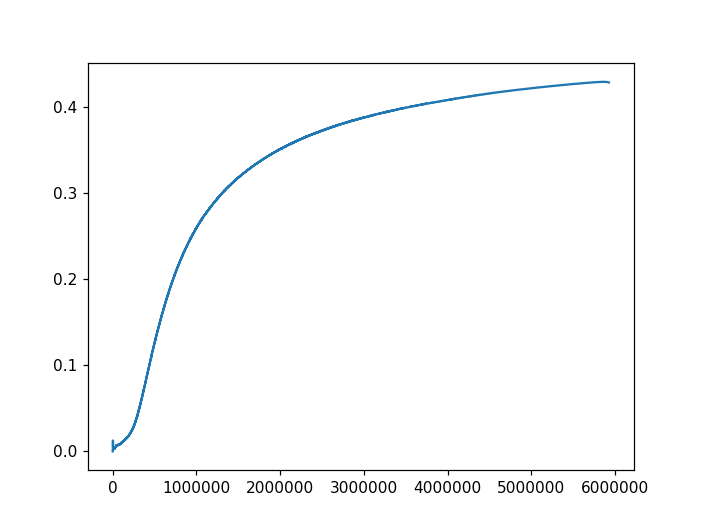

In [17]:
%matplotlib notebook

plt.plot(np.arange(1, df.shape[0] + 1), fdr)

In [18]:
fdr_threshold = 0.05
cutoff = df.shape[0] - np.flatnonzero(fdr[::-1] < fdr_threshold)[0]
selection = order[:cutoff]
selection = selection[~df['Decoy'].values[selection]]

In [19]:
np.unique(df['Peptide_sequence'][selection]).shape

(9707,)

In [9]:
df.ix[selection].to_csv(
    "/home/sander/Documents/Proteomics/data/swath/LFQ_TT5600_SWATH_Micro_120_Min_Ecoli_01_05fdr.annotation.csv"
)

<ipython-input-9-bb4c5660d333>:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  df.ix[selection].to_csv(
